# Explore TM-Align Results

In [278]:
import pandas as pd
results = pd.read_parquet('tmalign_rmsd_full.parquet').sort_values(by=['tm_score_norm_ref_p1'], ascending=False)
tm_score_threshold = 0.5
rmsd_threshold = 3
# Scores below 0.17 correspond to randomly chosen unrelated proteins whereas structures with a score higher than 0.5 assume generally the same fold in SCOP/CATH. (Zhang)
# Quantitative study shows that proteins of TM-score = 0.5 have a posterior probability of 37% in the same CATH topology family and of 13% in the same SCOP fold family. 
# The probabilities increase rapidly when TM-score > 0.5. (Wikipedia)
print('Num. Results:', len(results))

Num. Results: 64400


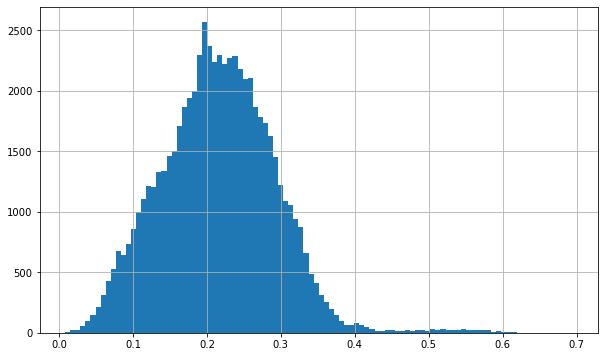

In [279]:
results.tm_score_norm_ref_p1.astype(float).hist(bins=100, figsize=(10,6));

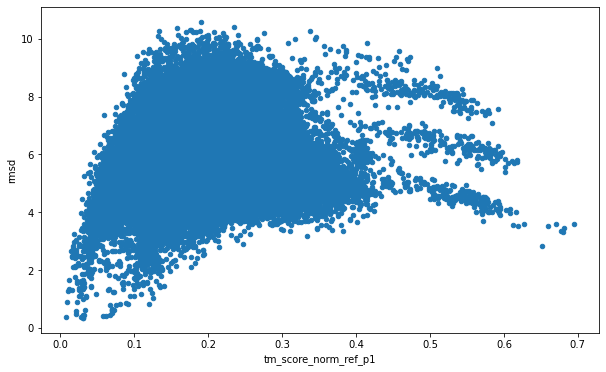

In [280]:
results[['rmsd', 'tm_score_norm_ref_p1']].astype(float).plot(x='tm_score_norm_ref_p1', y='rmsd', kind='scatter', figsize=(10,6));

In [233]:
results[results.tm_score_norm_ref_p1.astype(float) > tm_score_threshold]

,query_protein,query_protein_length,target_protein,target_protein_length,aligned_length,rmsd,tm_score_norm_ref_p1
0,AF-Q8N1S5-F1-model_v1,342,AF-Q13433-F1-model_v1,755,278,3.59,0.69422
0,AF-Q8N1S5-F1-model_v1,342,AF-Q6P5W5-F1-model_v1,647,279,3.47,0.68158
0,AF-Q8N1S5-F1-model_v1,342,AF-Q504Y0-F1-model_v1,691,269,3.31,0.6798
0,AF-Q8N1S5-F1-model_v1,342,AF-Q9BRY0-F1-model_v1,314,273,3.36,0.67734
0,AF-Q8N1S5-F1-model_v1,342,AF-Q9ULF5-F1-model_v1,831,270,3.58,0.66977
...,...,...,...,...,...,...,...
0,AF-Q8N1S5-F1-model_v1,342,AF-Q12802-F1-model_v1,12413,273,6.35,0.50196
0,AF-Q8N1S5-F1-model_v1,342,AF-P78509-F1-model_v1,12642,274,6.12,0.50181
0,AF-Q8N1S5-F1-model_v1,342,AF-P46939-F1-model_v1,12392,275,6.32,0.50092
0,AF-P48449-F1-model_v1,732,AF-Q07954-F1-model_v1,12910,592,8.32,0.50053


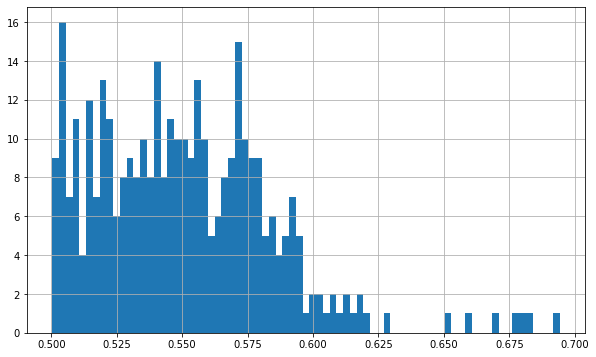

In [281]:
results[results.tm_score_norm_ref_p1.astype(float) > tm_score_threshold].tm_score_norm_ref_p1.astype(float).hist(bins=75, figsize=(10,6));

In [235]:
# We used three different RMSD classifications for docking solutions: (a) good solution when RMSD ≤ 2.0 Å [8,22], (b) acceptable solutions when RMSD is between 2.0 and 3.0 Å, and (c) bad solutions when RMSD ≥ 3.0 Å. 
# https://www.mdpi.com/1420-3049/23/5/1038/htm
results[(results.tm_score_norm_ref_p1.astype(float) > tm_score_threshold) & (results.rmsd.astype(float) < rmsd_threshold)]

,query_protein,query_protein_length,target_protein,target_protein_length,aligned_length,rmsd,tm_score_norm_ref_p1
0,AF-Q8N1S5-F1-model_v1,342,AF-Q9NUM3-F1-model_v1,307,254,2.84,0.65136


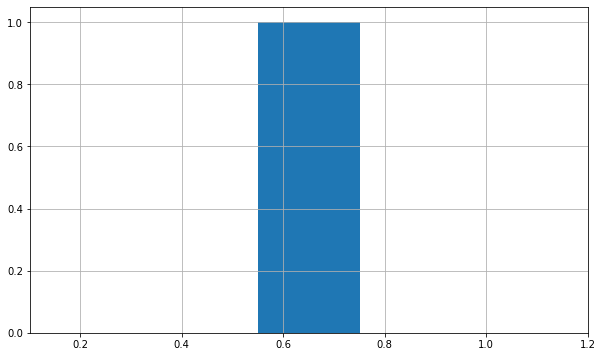

In [282]:
results[(results.tm_score_norm_ref_p1.astype(float) > tm_score_threshold) & (results.rmsd.astype(float) <= rmsd_threshold)].tm_score_norm_ref_p1.astype(float).hist(bins=5, figsize=(10,6));

# TM-Align Function

In [259]:
import io
import os
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq

In [284]:
# generates protein combinations, runs tmalign on each, and saves results into a df

def process_report(p1, p2, pld):
    aligned_length, rmsd, tm_score_norm_ref_p1, p1_length, p2_length = 0,0,0,0,0
    result = []
    for line in pld:
        if 'Aligned length' in line:
            bits = line.split(',')
            aligned_length = int(''.join([n for n in bits[0] if n in '.0123456789']))
            rmsd = float(''.join([n for n in bits[1] if n in '.0123456789']))
        if 'normalized by length of Chain_1' in line:
            bits = line.split('=')
            tm_score_norm_ref_p1 = float(''.join([n for n in bits[1][:10] if n in '.0123456789']))
        if 'Length of Chain_1' in line:
            p1_length = int(''.join([n for n in line[18:] if n in '.0123456789']))
        if 'Length of Chain_2' in line:
            p2_length = int(''.join([n for n in line[18:] if n in '.0123456789']))
    result = [p1, p1_length, p2, p2_length, aligned_length, rmsd, tm_score_norm_ref_p1]
    return result


def tmalign(combinations, cluster_labels=None):
    result = []
    total = (len(combinations)**2)-len(combinations)
    counter = 0
    
    if cluster_labels is None:
        for pair in combinations:
            if pair[0] != pair[1]:
                cmd = f'/home/jupyter/pss/tmalign/TMalign /home/jupyter/pss/final_pdbs/{pair[0]}.pdb /home/jupyter/pss/final_pdbs/{pair[1]}.pdb'
                tmalign_report = os.popen(cmd).readlines()
                result.append(process_report(pair[0], pair[1], tmalign_report))
    table = pa.Table.from_pandas(pd.DataFrame(result, columns=['query_protein', 'query_protein_length', 'target_protein', 
                                                               'target_protein_length', 'aligned_length', 'rmsd', 'tmalign_score']))
    pq.write_table(table, 'pairs_tmalign_rmsd.parquet')


combinations = [['AF-Q8N1S5-F1-model_v1', 'AF-Q13433-F1-model_v1'], ['AF-Q8N1S5-F1-model_v1', 'AF-Q9ULF5-F1-model_v1']]
cluster_labls = None
    
tmalign(combinations, cluster_labls)

pd.read_parquet('pairs_tmalign_rmsd.parquet')

,query_protein,query_protein_length,target_protein,target_protein_length,aligned_length,rmsd,tmalign_score
0,AF-Q8N1S5-F1-model_v1,342,AF-Q13433-F1-model_v1,755,278,3.59,0.69422
1,AF-Q8N1S5-F1-model_v1,342,AF-Q9ULF5-F1-model_v1,831,270,3.58,0.66977
